In [97]:
from processing_functions import *
%matplotlib inline

In [98]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [99]:
# Drop profy features
proxy_features_personal_dataset = [
    # 'fstcan_exitdays', # Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitstat', # Status of the participant at exit for first cancer incidence. Only cancers occuring during the trial are used to determine exit.
    'f_dthovar', # Is ovarian cancer the underlying cause of death? This conclusion is based on the information from the death certificate and death review.
    'f_codeath_cat', # Categorized underlying cause of death.
    'f_cancersite', # Underlying cause of death from cancer.
    'f_seer_death', # Underlying cause of death.
    'd_codeath_cat', # Categorized underlying cause of death.
    'd_dthovar', # Is Ovarian Cancer The Underlying Cause Of Death?
    'd_cancersite', # 
    'd_seer_death', # Underlying cause of death.
    'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry? 
    'ph_ovar_sqx', # 
    'entrydays_muq', # 
    'ca125_src1', # 
    'ph_ovar_dhq', # 
    'dth_days', # 
    ]

proxy_features_screen_dataset = [
    'QAMETHOD',
    'tvudays_pvis1',
    'tvudays_pvis2',
    'tvudays_pvis3',
    'tvures_qvis1',
    'tvures_qvis2',
    'tvures_qvis3',
    'tvu_assess_days_q',
    'ca125ii_src', # 
    'medcomp', # 
    'ca125_src', # 
]

personal_data = personal_data.drop(proxy_features_personal_dataset, axis=1)
screen_data = screen_data.drop(proxy_features_screen_dataset, axis=1)

# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_', 'build'], ['ovar_cancer', 'ovar_cancer_diagdays', 'ovar_exitdays'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = screen_abnorm_data.drop('build', axis=1)

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of build cols: 4
['build

In [100]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


# TODO: should `inad_` features to be used to disqualify exam result? 
# TODO: should we drop features that are 95% missing and above? Some of the features seem to be exclusive 

## `TODO:` Determining which feature to use for determining when the patient got cancer

In [101]:
personal_data_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].describe().T

,count,mean,std,min,25%,50%,75%,max
ovar_cancer_diagdays,613.0,2751.973899,1751.601513,5.0,1213.0,2745.0,4137.0,6895.0
fstcan_exitdays,613.0,2512.432300,1596.348029,5.0,1068.0,2564.0,3826.0,5800.0
ovar_exitdays,613.0,2647.187602,1606.080617,5.0,1213.0,2745.0,3929.0,5804.0


In [102]:
len(personal_data_cancer[personal_data_cancer['ovar_cancer_diagdays']<5*365])

221

- '`ovar_cancer_diagdays`' - Ovarian Confirmed Cancer Diagnosis Days
- '`fstcan_exitdays`' - Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
- '`ovar_exitdays`' - Days from trial entry (randomization) to cancer diagnosis for participants with ovarian, peritoneal, or fallopian tube cancer, or to trial exit otherwise.

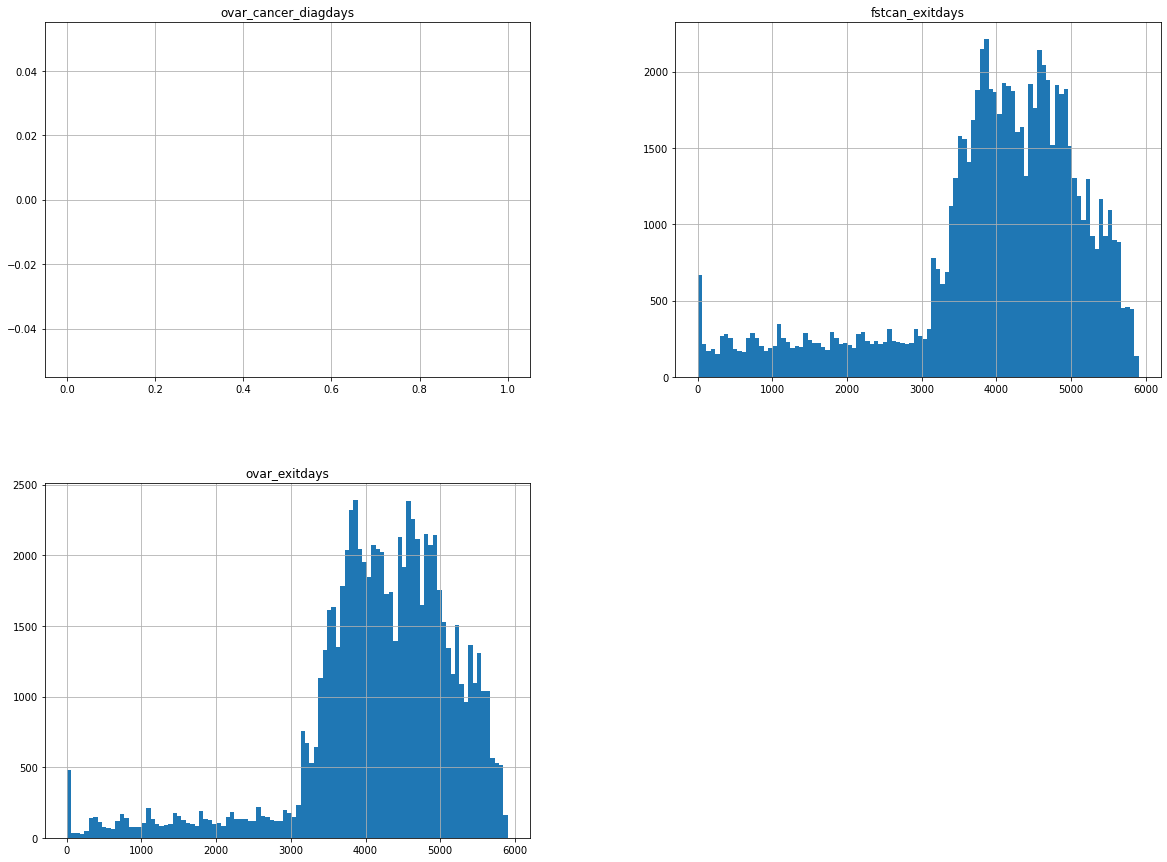

In [103]:
personal_data_no_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].hist(figsize=(20,15), bins=100);

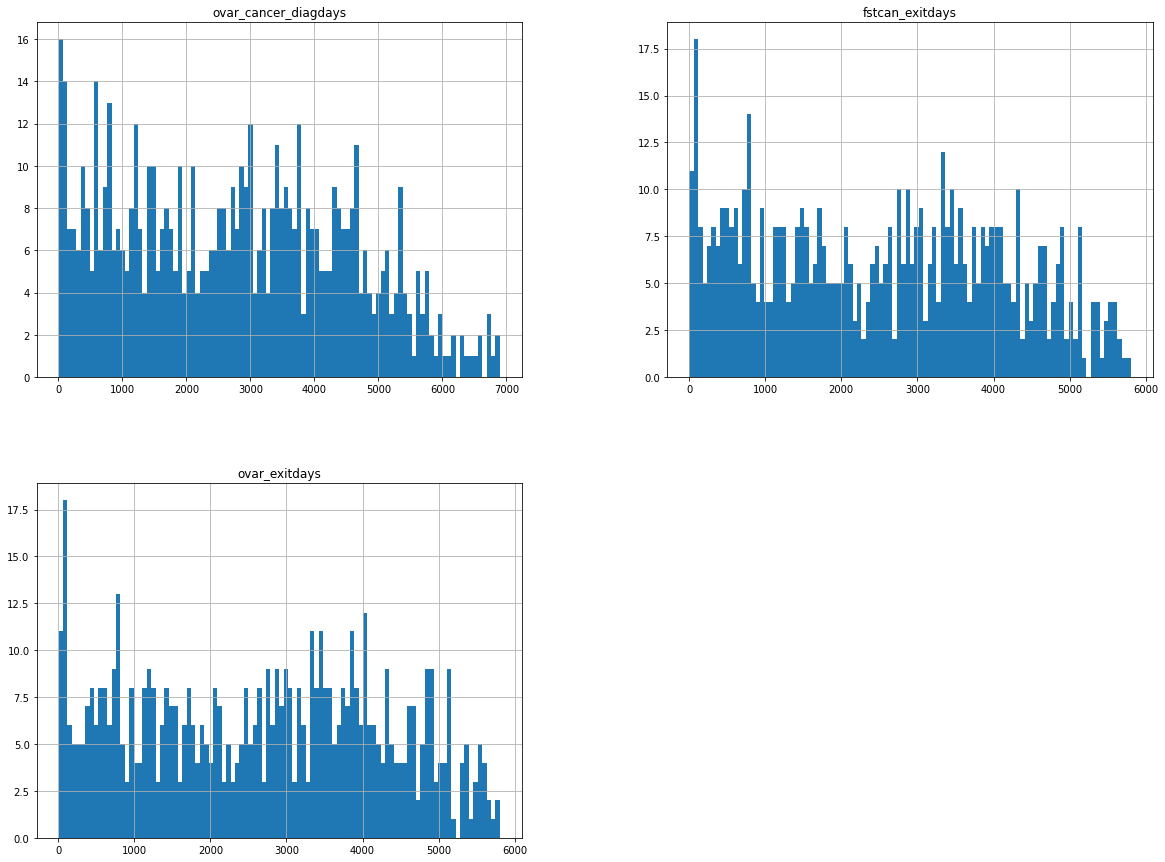

In [104]:
personal_data_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].hist(figsize=(20,15), bins=100);

## Missing Values Analysis
`['study_yr', 'side', 'source', 'VISIT', 'sbcd']`

In [105]:

# Prints the table of missing values with columns for df filtered for each of the values of on_col
def df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=True):
    iterate_over_on_col = sorted(df[on_col].unique())
    suffixes=[]
    # since get_cols_missing_percentage will produce columns with the same names, we want to create suffixes to differentiate over on_col values
    for on_col_val in iterate_over_on_col:
        suffixes.append(f'_{on_col}_{on_col_val}')
    # We are going to merge all of the 
    df_missing = None
    for on_col_val in iterate_over_on_col:

        df_on_col = df[df[on_col] == on_col_val]

        df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}', show_missing=show_missing)
        
        if df_missing is not None:
            df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
        else:
            df_missing = df_missing_on_col
    print_df(df_missing)


def df_filter_val_distribution(sourse_df, on_col, make_unique_over_cols, name, hist=True, cutoff_percentage=0):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    num_records, num_unique = print_records_vs_unique(sourse_df, 'plco_id', name)
    unique_combinations_col_vals = sorted(unique_combinations_col_vals)
    unique_records = [{} for _ in range(len(unique_combinations_col_vals)+1)]
    unique_records[0] = {
            'filtered_on': f'{name} total'
        }
    
    iterate_over_on_col = sorted(sourse_df[on_col].unique())
    for on_col_val in iterate_over_on_col:
        num_records, num_unique = print_records_vs_unique(sourse_df[sourse_df[on_col] == on_col_val], 'plco_id', f'{name} with {on_col}_{on_col_val}')
        unique_records[0][f'num_records_{on_col}:{on_col_val}'] = num_records
        unique_records[0][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
    print()
    print()
    for j in range(len(unique_combinations_col_vals)):
        unique_combination = unique_combinations_col_vals[j]
        filter = True
        filtered_on = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            filter = filter & (sourse_df[variable_col] == val)
            filtered_on += f'{variable_col}: {val} '
        df = sourse_df[filter]
        if len(make_unique_over_cols) > 0:
            df = df.drop(make_unique_over_cols, axis=1)

        title = f'{name} filtered on {filtered_on}'
        print(title)

        df_missing = None
        unique_records[j+1]['filtered_on'] = title
        for on_col_val in iterate_over_on_col:
            df_on_col = df[df[on_col] == on_col_val]
            num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
            df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
            unique_records[j+1][f'num_records_{on_col}:{on_col_val}'] = num_records
            unique_records[j+1][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
            if hist:
                fig, ax = plt.subplots(1, 1, figsize=(20,15))
                df.hist(ax=ax, bins=30)
                plt.show()
        df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=False)
        df = impute_with_val(df, df.columns, -1)
        print('\n\n')
    print_df(pd.DataFrame(unique_records).sort_values('filtered_on'))

def df_filter_val_distribution_on_cancer(source_df, make_unique_over_cols, name, hist=False, cutoff_percentage=0):
    df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
    df_cancer['cancer'] = 1
    df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
    df_no_cancer['cancer'] = 0
    df = pd.concat([df_cancer, df_no_cancer], axis=0)
    df_filter_val_distribution(df, 'cancer', make_unique_over_cols, name, hist=hist, cutoff_percentage=cutoff_percentage)

In [106]:
print(personal_data.columns.to_list())

['ovar_cancer', 'plco_id', 'ovar_exitdays', 'ovar_cancer_diagdays', 'biopolink0', 'biopolink1', 'biopolink2', 'biopolink3', 'biopolink4', 'biopolink5', 'tvu_result0', 'tvu_result1', 'tvu_result2', 'tvu_result3', 'ca125_result0', 'ca125_result1', 'ca125_result2', 'ca125_result3', 'ca125_result4', 'ca125_result5', 'ca125_level0', 'ca125_level1', 'ca125_level2', 'ca125_level3', 'ca125_level4', 'ca125_level5', 'ca125_src0', 'ca125_src2', 'ca125_src3', 'ca125_src4', 'ca125_src5', 'ca125ii_level0', 'ca125ii_level1', 'ca125ii_level2', 'ca125ii_level3', 'ca125ii_level4', 'ca125ii_level5', 'orem_fyro', 'ca125_prot', 'ovary_trial_flag', 'ca125_days0', 'ca125_days1', 'ca125_days2', 'ca125_days3', 'ca125_days4', 'ca125_days5', 'tvu_days0', 'tvu_days1', 'tvu_days2', 'tvu_days3', 'educat', 'marital', 'occupat', 'pipe', 'cigar', 'sisters', 'brothers', 'asp', 'ibup', 'fmenstr', 'menstrs', 'miscar', 'tubal', 'tuballig', 'bbd', 'benign_ovcyst', 'endometriosis', 'uterine_fib', 'mammo_history', 'papsmear_

In [107]:
make_unique_over_cols = ['dummy']
df = personal_data
df['dummy'] = 0
df_filter_val_distribution_on_cancer(df, make_unique_over_cols, 'Personal Data', hist=False, cutoff_percentage=0)

Num of records in Personal Data dataset: 78209


C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


Num of unique plco_id in Personal Data dataset: 78209
Num of records in Personal Data with cancer_0 dataset: 77596
Num of unique plco_id in Personal Data with cancer_0 dataset: 77596
Num of records in Personal Data with cancer_1 dataset: 613
Num of unique plco_id in Personal Data with cancer_1 dataset: 613


Personal Data filtered on dummy: 0 
Num of records in Personal Data filtered on dummy: 0  with cancer_0 dataset: 77596
Num of unique plco_id in Personal Data filtered on dummy: 0  with cancer_0 dataset: 77596
177 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'bq_returned', 'race7', 'is_dead_with_cod', 'is_dead', 'mortality_exitage', 'mortality_exitstat', 'mortality_exitdays', 'ph_any_trial', 'ph_ovar_trial', 'in_TGWAS_population', 'center', 'arm', 'sex', 'age', 'agelevel', 'dual', 'reconsent_outcome', 'reconsent_outcome_days', 'fstcan_exitage', 'fstcan_exitdays', 'rndyear', 'ovary_trial_flag', 'cancer', 'biopolink5', 'plco_id', 'ovar_exitdays', 'biopolin

In [108]:
make_unique_over_cols = ['dummy']
df = personal_data
df['dummy'] = 0
get_cols_missing_percentage(0, df, f'').to_csv(f'./missing_features/personal_data_missing_over_{65}.csv', index=False)

177 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'bq_returned', 'race7', 'is_dead_with_cod', 'is_dead', 'mortality_exitage', 'mortality_exitstat', 'mortality_exitdays', 'ph_any_trial', 'ph_ovar_trial', 'in_TGWAS_population', 'center', 'arm', 'sex', 'age', 'agelevel', 'dual', 'reconsent_outcome', 'reconsent_outcome_days', 'fstcan_exitage', 'fstcan_exitdays', 'rndyear', 'ovary_trial_flag', 'dummy', 'biopolink5', 'plco_id', 'ovar_exitdays', 'biopolink0', 'biopolink1', 'biopolink2', 'biopolink3', 'biopolink4', 'bq_compdays', 'entrydays_bq', 'ph_any_bq', 'entryage_bq', 'menstrs_stat_type', 'post_menopausal', 'bq_age', 'ph_ovar_bq', 'smoked_f', 'cig_stat', 'ovariesr_f', 'preg_f', 'ca125_history', 'usound_history', 'pelvic_history', 'cigpd_f', 'hyster_f', 'livec', 'horm_stat', 'horm_f', 'mammo_history', 'bcontr_f', 'marital', 'papsmear_history', 'pregc', 'educat', 'fmenstr', 'bcontrt', 'asp', 'miscar', 'fh_cancer', 'asppd', 'tuballig', 'tubal', 'trypreg', 'bq_admi

In [109]:
make_unique_over_cols = ['dummy']
df = screen_data
df['dummy'] = 0
df_filter_val_distribution_on_cancer(df, make_unique_over_cols, 'Screen Data', hist=False, cutoff_percentage=0)

Num of records in Screen Data dataset: 150993
Num of unique plco_id in Screen Data dataset: 30849


C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


Num of records in Screen Data with cancer_0 dataset: 149793
Num of unique plco_id in Screen Data with cancer_0 dataset: 30552
Num of records in Screen Data with cancer_1 dataset: 1200
Num of unique plco_id in Screen Data with cancer_1 dataset: 297


Screen Data filtered on dummy: 0 
Num of records in Screen Data filtered on dummy: 0  with cancer_0 dataset: 149793
Num of unique plco_id in Screen Data filtered on dummy: 0  with cancer_0 dataset: 30552
69 columns were over 0 missing. This is the list of columns: ['study_yr', 'ovar_result', 'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr', 'ovcyst_suml', 'ovcyst_sum', 'visl', 'visr', 'visboth', 'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'ca125_result', 'tvu_result', 'cancer', 'ovar_days', 'ca125_days', 'ca125_level', 'ca125ii_assess_days', 'tvu_days', 'tvu_ref', 'phycons', 'detr_p', 'detl_p', 'tvures_pvis1', 'ovcyst_diam', 'ovcyst_vol', 'ovary_diam', 'ovary_vol', 'physid', 'ovcyst_diamr', 'ovcyst_volr', 'ovary_

In [110]:
make_unique_over_cols = ['dummy']
df = screen_data
df['dummy'] = 0
get_cols_missing_percentage(0, df, f'').to_csv(f'./missing_features/screen_data_missing_over_{65}.csv', index=False)

69 columns were over 0 missing. This is the list of columns: ['study_yr', 'ovar_result', 'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr', 'ovcyst_suml', 'ovcyst_sum', 'visl', 'visr', 'visboth', 'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'ca125_result', 'tvu_result', 'dummy', 'ovar_days', 'ca125_days', 'ca125_level', 'ca125ii_assess_days', 'tvu_days', 'tvu_ref', 'phycons', 'detr_p', 'detl_p', 'tvures_pvis1', 'ovcyst_diam', 'ovcyst_vol', 'ovary_diam', 'ovary_vol', 'physid', 'ovcyst_diamr', 'ovcyst_volr', 'ovary_diamr', 'ovary_volr', 'rtran_p', 'rlong_p', 'rantero_p', 'rvol_p', 'ovcyst_voll', 'ovcyst_diaml', 'ovary_voll', 'ovary_diaml', 'lantero_p', 'llong_p', 'ltran_p', 'lvol_p', 'ovcyst_solid', 'ovcyst_outline', 'ovcyst_solidr', 'detl_q', 'detr_q', 'ovcyst_outliner', 'ca125i_assess_days', 'ovcyst_solidl', 'ovcyst_outlinel', 'rvol_q', 'rtran_q', 'rlong_q', 'rantero_q', 'ltran_q', 'llong_q', 'lantero_q', 'lvol_q', 'tvures_pvis2', 'tvures_pvis3']
The table of 

In [111]:
make_unique_over_cols = ['dummy']
df = screen_abnorm_data
df['dummy'] = 0
df_filter_val_distribution_on_cancer(df, make_unique_over_cols, 'Screen Abnormalities Data', hist=False, cutoff_percentage=0)

Num of records in Screen Abnormalities Data dataset: 20186
Num of unique plco_id in Screen Abnormalities Data dataset: 6992
Num of records in Screen Abnormalities Data with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities Data with cancer_0 dataset: 6881
Num of records in Screen Abnormalities Data with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities Data with cancer_1 dataset: 111


Screen Abnormalities Data filtered on dummy: 0 
Num of records in Screen Abnormalities Data filtered on dummy: 0  with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities Data filtered on dummy: 0  with cancer_0 dataset: 6881
16 columns were over 0 missing. This is the list of columns: ['VISIT', 'side', 'sbcd', 'study_yr', 'source', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'cancer', 'maxdi', 'solid', 'echo', 'volum', 'sepst', 'cyst', 'cystw']
The table of features missing over 0 percentage: 
+------------------------+-------------------

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


In [112]:
make_unique_over_cols = ['study_yr']
df_filter_val_distribution_on_cancer(screen_data, make_unique_over_cols, 'Screen Data', hist=False, cutoff_percentage=0)

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


Num of records in Screen Data dataset: 150993
Num of unique plco_id in Screen Data dataset: 30849
Num of records in Screen Data with cancer_0 dataset: 149793
Num of unique plco_id in Screen Data with cancer_0 dataset: 30552
Num of records in Screen Data with cancer_1 dataset: 1200
Num of unique plco_id in Screen Data with cancer_1 dataset: 297


Screen Data filtered on study_yr: 0 
Num of records in Screen Data filtered on study_yr: 0  with cancer_0 dataset: 28638
Num of unique plco_id in Screen Data filtered on study_yr: 0  with cancer_0 dataset: 28638
69 columns were over 0 missing. This is the list of columns: ['cancer', 'ovar_result', 'dummy', 'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr', 'ovcyst_suml', 'ovcyst_sum', 'ca125_result', 'visl', 'visboth', 'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'visr', 'tvu_result', 'ovar_days', 'ca125_days', 'ca125_level', 'tvu_days', 'phycons', 'tvu_ref', 'detr_p', 'detl_p', 'tvures_pvis1', 'ca125ii_assess_days', '

In [113]:
df_missing_value = get_cols_missing_percentage(0, personal_data, 'personal_data')
df_missing_value[df_missing_value['column_name'].isin(['ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays'])]

177 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'bq_returned', 'race7', 'is_dead_with_cod', 'is_dead', 'mortality_exitage', 'mortality_exitstat', 'mortality_exitdays', 'ph_any_trial', 'ph_ovar_trial', 'in_TGWAS_population', 'center', 'arm', 'sex', 'age', 'agelevel', 'dual', 'reconsent_outcome', 'reconsent_outcome_days', 'fstcan_exitage', 'fstcan_exitdays', 'rndyear', 'ovary_trial_flag', 'dummy', 'biopolink5', 'plco_id', 'ovar_exitdays', 'biopolink0', 'biopolink1', 'biopolink2', 'biopolink3', 'biopolink4', 'bq_compdays', 'entrydays_bq', 'ph_any_bq', 'entryage_bq', 'menstrs_stat_type', 'post_menopausal', 'bq_age', 'ph_ovar_bq', 'smoked_f', 'cig_stat', 'ovariesr_f', 'preg_f', 'ca125_history', 'usound_history', 'pelvic_history', 'cigpd_f', 'hyster_f', 'livec', 'horm_stat', 'horm_f', 'mammo_history', 'bcontr_f', 'marital', 'papsmear_history', 'pregc', 'educat', 'fmenstr', 'bcontrt', 'asp', 'miscar', 'fh_cancer', 'asppd', 'tuballig', 'tubal', 'trypreg', 'bq_admi

,column_name,num_missing,num_present,percent_missing
fstcan_exitdays,fstcan_exitdays,0,78209,0.000000
ovar_exitdays,ovar_exitdays,0,78209,0.000000
ovar_cancer_diagdays,ovar_cancer_diagdays,77596,613,99.216203


In [114]:
get_cols_missing_percentage(95, screen_data, 'screen_data')

17 columns were over 95 missing. This is the list of columns: ['ovcyst_solidr', 'detl_q', 'detr_q', 'ovcyst_outliner', 'ca125i_assess_days', 'ovcyst_solidl', 'ovcyst_outlinel', 'rvol_q', 'rtran_q', 'rlong_q', 'rantero_q', 'ltran_q', 'llong_q', 'lantero_q', 'lvol_q', 'tvures_pvis2', 'tvures_pvis3']
The table of features missing over 95 percentage: 
+--------------------+--------------------+---------------+---------------+-------------------+
|                    | column_name        |   num_missing |   num_present |   percent_missing |
|--------------------+--------------------+---------------+---------------+-------------------|
| ovcyst_solidr      | ovcyst_solidr      |        143469 |          7524 |           95.017  |
| detl_q             | detl_q             |        143541 |          7452 |           95.0647 |
| detr_q             | detr_q             |        143542 |          7451 |           95.0653 |
| ovcyst_outliner    | ovcyst_outliner    |        143754 |          7239 

,column_name,num_missing,num_present,percent_missing
ovcyst_solidr,ovcyst_solidr,143469,7524,95.016988
detl_q,detl_q,143541,7452,95.064672
detr_q,detr_q,143542,7451,95.065334
ovcyst_outliner,ovcyst_outliner,143754,7239,95.205738
ca125i_assess_days,ca125i_assess_days,143844,7149,95.265343
ovcyst_solidl,ovcyst_solidl,143924,7069,95.318326
ovcyst_outlinel,ovcyst_outlinel,144177,6816,95.485883
rvol_q,rvol_q,147235,3758,97.511143
rtran_q,rtran_q,147235,3758,97.511143
rlong_q,rlong_q,147235,3758,97.511143


In [115]:
print_records_vs_unique_for(screen_data, 'plco_id', 'screen', 'study_yr')

Num of records in screen dataset: 150993
Num of unique plco_id in screen dataset: 30849
Num of records in screen.study_yr=0 dataset: 28919
Num of unique plco_id in screen.study_yr=0 dataset: 28919
Num of records in screen.study_yr=1 dataset: 27607
Num of unique plco_id in screen.study_yr=1 dataset: 27607
Num of records in screen.study_yr=2 dataset: 26637
Num of unique plco_id in screen.study_yr=2 dataset: 26637
Num of records in screen.study_yr=3 dataset: 25459
Num of unique plco_id in screen.study_yr=3 dataset: 25459
Num of records in screen.study_yr=4 dataset: 20146
Num of unique plco_id in screen.study_yr=4 dataset: 20146
Num of records in screen.study_yr=5 dataset: 22225
Num of unique plco_id in screen.study_yr=5 dataset: 22225


The question is how should we merge the duplicate records per participant id since for each set of features `['study_yr', 'side', 'source', 'VISIT', 'sbcd']` a participant might have records with different values for the rest of the columns. If we treat the rest of the features as unique based on the combination of these: `['study_yr', 'side', 'source', 'VISIT', 'sbcd']`, we would produce a massive number of missing features since there are 144 combinations of these `['study_yr', 'side', 'source', 'VISIT', 'sbcd']` features. So, assuming 100% presence of data, it would mean that after converting all the data into features using that method would result in there being at most 1 record per 144 rows of data. But in reality it results in 840 columns with no data whatsoever. This is an issue. The question is how to merge that data into featues. 

## `TODO:`
- for `VISIT` we can take an average for a year
- for `sbcd` (Subrecord Number) we can take an average for a year. Not sure what is the difference between different subrecords
- for `source` (Source of Report (TVU/TVQ)) - not sure how to deal with this one
- for `study_yr` and `side` I propose creating unique features over the combination of these values (10 combinations total 5 years and 2 sides [L, R])

The plots below plot the distribution of values over the particular value of some feature e.g. `source` or `study_yr`

In [116]:
make_unique_over_cols = ['source']
df_filter_val_distribution_on_cancer(screen_abnorm_data, make_unique_over_cols, 'Screen Abnormalities', hist=False, cutoff_percentage=0)

Num of records in Screen Abnormalities dataset: 20186
Num of unique plco_id in Screen Abnormalities dataset: 6992
Num of records in Screen Abnormalities with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities with cancer_0 dataset: 6881
Num of records in Screen Abnormalities with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities with cancer_1 dataset: 111


Screen Abnormalities filtered on source: TVQ 
Num of records in Screen Abnormalities filtered on source: TVQ  with cancer_0 dataset: 1703
Num of unique plco_id in Screen Abnormalities filtered on source: TVQ  with cancer_0 dataset: 1097
16 columns were over 0 missing. This is the list of columns: ['VISIT', 'side', 'sbcd', 'study_yr', 'solid', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'dummy', 'cancer', 'echo', 'maxdi', 'volum', 'sepst', 'cyst', 'cystw']
The table of features missing over 0 percentage: 
+------------------------+------------------------+---------------+---------------+

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


In [117]:
make_unique_over_cols = ['side']
df_filter_val_distribution_on_cancer(screen_abnorm_data, make_unique_over_cols, 'Screen Abnormalities', hist=False, cutoff_percentage=0)

Num of records in Screen Abnormalities dataset: 20186
Num of unique plco_id in Screen Abnormalities dataset: 6992
Num of records in Screen Abnormalities with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities with cancer_0 dataset: 6881
Num of records in Screen Abnormalities with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities with cancer_1 dataset: 111


Screen Abnormalities filtered on side: L 
Num of records in Screen Abnormalities filtered on side: L  with cancer_0 dataset: 9520
Num of unique plco_id in Screen Abnormalities filtered on side: L  with cancer_0 dataset: 4011
16 columns were over 0 missing. This is the list of columns: ['VISIT', 'sbcd', 'study_yr', 'source', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'dummy', 'cancer', 'solid', 'echo', 'maxdi', 'volum', 'sepst', 'cyst', 'cystw']
The table of features missing over 0 percentage: 
+------------------------+------------------------+---------------+---------------+----------

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


In [118]:
screen_abnorm_data = screen_abnorm_data.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})
make_unique_over_cols = ['study_yr']
df_filter_val_distribution_on_cancer(screen_abnorm_data, make_unique_over_cols, 'Screen Abnormalities', hist=False, cutoff_percentage=0)

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\3219494209.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


Num of records in Screen Abnormalities dataset: 20186
Num of unique plco_id in Screen Abnormalities dataset: 6992
Num of records in Screen Abnormalities with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities with cancer_0 dataset: 6881
Num of records in Screen Abnormalities with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities with cancer_1 dataset: 111


Screen Abnormalities filtered on study_yr: 0 
Num of records in Screen Abnormalities filtered on study_yr: 0  with cancer_0 dataset: 5296
Num of unique plco_id in Screen Abnormalities filtered on study_yr: 0  with cancer_0 dataset: 3478
16 columns were over 0 missing. This is the list of columns: ['VISIT', 'side', 'sbcd', 'source', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'dummy', 'cancer', 'echo', 'maxdi', 'solid', 'cyst', 'sepst', 'cystw', 'volum']
The table of features missing over 0 percentage: 
+------------------------+------------------------+---------------+---------------+--

## Merging data into features and mean imputing


## `TODO:` should we mean impute before and after or just after? Also, should we use labeled imputation?

In [119]:
get_missing_values_cols(screen_data)

,column_name,num_missing,num_present,percent_missing
study_yr,study_yr,0,150993,0.000000
ovar_result,ovar_result,0,150993,0.000000
ovcyst_morphr,ovcyst_morphr,0,150993,0.000000
ovcyst_morphl,ovcyst_morphl,0,150993,0.000000
ovcyst_morph,ovcyst_morph,0,150993,0.000000
...,...,...,...,...
llong_q,llong_q,147369,3624,97.599889
lantero_q,lantero_q,147369,3624,97.599889
lvol_q,lvol_q,147373,3620,97.602538
tvures_pvis2,tvures_pvis2,149773,1220,99.192016


In [120]:
# Mean impute before converting into features
# screen_data = mean_impute(screen_data, select_numeric_columns(screen_data))
# Turn screen dataset each year into a feature
merged_data_screen = merge_df_into_features(screen_data, 'plco_id', ['study_yr'])
print_records_vs_unique(merged_data_screen, 'plco_id', 'merged_data_screen')
# Mean impute after converting into features
# merged_data_screen = mean_impute(merged_data_screen, select_numeric_columns(merged_data_screen))

# Drop features that are 100% missing
merged_data_screen = drop_cols_missing_percentage(100, merged_data_screen, 'merged_data_screen')

Num of records in merged_data_screen dataset: 30849
Num of unique plco_id in merged_data_screen dataset: 30849
Removing features that are over 100% missing
95 columns were over 100 missing. This is the list of columns: ['ovcyst_outlinel__study_yr_5', 'ca125i_assess_days__study_yr_3', 'ca125i_assess_days__study_yr_5', 'ovcyst_solid__study_yr_5', 'ovary_vol__study_yr_5', 'ovcyst_voll__study_yr_5', 'ovcyst_outline__study_yr_5', 'ovary_volr__study_yr_5', 'ovcyst_volr__study_yr_5', 'ovary_voll__study_yr_5', 'ovary_diaml__study_yr_5', 'ovary_diamr__study_yr_5', 'tvures_pvis3__study_yr_3', 'ovcyst_diam__study_yr_5', 'ovcyst_vol__study_yr_5', 'ovcyst_diaml__study_yr_5', 'ovcyst_diamr__study_yr_5', 'ovary_diam__study_yr_5', 'ovary_voll__study_yr_4', 'detl_p__study_yr_4', 'ovcyst_outline__study_yr_4', 'ovcyst_solid__study_yr_4', 'ovcyst_outlinel__study_yr_4', 'ovcyst_solidl__study_yr_4', 'rlong_p__study_yr_5', 'rantero_q__study_yr_5', 'rantero_p__study_yr_5', 'ltran_q__study_yr_5', 'ltran_p__stu

In [121]:
print_records_vs_unique_for(screen_abnorm_data, 'plco_id', 'screen_abnorm_data', 'study_yr')

Num of records in screen_abnorm_data dataset: 20186
Num of unique plco_id in screen_abnorm_data dataset: 6992
Num of records in screen_abnorm_data.study_yr=0 dataset: 5418
Num of unique plco_id in screen_abnorm_data.study_yr=0 dataset: 3546
Num of records in screen_abnorm_data.study_yr=1 dataset: 5029
Num of unique plco_id in screen_abnorm_data.study_yr=1 dataset: 3305
Num of records in screen_abnorm_data.study_yr=2 dataset: 4902
Num of unique plco_id in screen_abnorm_data.study_yr=2 dataset: 3117
Num of records in screen_abnorm_data.study_yr=3 dataset: 4837
Num of unique plco_id in screen_abnorm_data.study_yr=3 dataset: 2959


In [122]:
# Mean Impute before converting into new features
screen_abnorm_data = mean_impute(screen_abnorm_data, select_numeric_columns(screen_abnorm_data))
# Turn screen dataset each year into a feature
make_unique_over_cols = ['study_yr', 'side', 'source', 'VISIT', 'sbcd']
merged_data_screen_abd = merge_df_into_features(screen_abnorm_data, 'plco_id', make_unique_over_cols)
print_records_vs_unique(merged_data_screen_abd, 'plco_id', 'screen_abnorm_data')
# Mean Impute before converting into new features
merged_data_screen_abd = mean_impute(merged_data_screen_abd, select_numeric_columns(merged_data_screen_abd))

# Drop features that are 100% missing
merged_data_screen_abd = drop_cols_missing_percentage(100, merged_data_screen_abd, 'merged_data_screen_abd')

# Convert Categorical features
merged_data_screen_abd = merged_data_screen_abd.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})

Num of records in screen_abnorm_data dataset: 6992
Num of unique plco_id in screen_abnorm_data dataset: 6992
Removing features that are over 100% missing
900 columns were over 100 missing. This is the list of columns: ['sepst__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'cyst__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cystw__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'echo__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'maxdi__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'volum__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cystw__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'build_cancers__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cyst__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'source__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'study_yr__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'sepst__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'sepst__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'solid__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'source__study_yr_1_side_1_source_1_VISIT_3_

In [123]:
# Drop profy features
proxy_features = [
    # 'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry?
    'ovar_cancer_diagdays', 
    'fstcan_exitdays', 
    'ovar_exitdays'
    ]
personal_data_cancer = personal_data_cancer.drop(proxy_features, axis=1)
personal_data_no_cancer = personal_data_no_cancer.drop(proxy_features, axis=1)

In [124]:

# Merge cancer patients dataset with screen dataset and see missing values
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how='left')
merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how='left')
merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')
# TODO: Number of people with records for each of the years
print(f"Number of people with cancer who have records for Screen Dataset: {len(personal_data_cancer.merge(merged_data_screen, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records for Abnormalities Dataset: {len(personal_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records in all datasets: {len(merged_data_cancer)}")
print(f"Number of people with cancer who have records for Screen Dataset: {len(personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records for Abnormalities Dataset: {len(personal_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records in all datasets: {len(merged_data_no_cancer)}")
# See missing values
cutoff_percentage = 1
cancer_missing_value = get_cols_missing_percentage(cutoff_percentage, merged_data_cancer, 'merged_data_cancer', show_missing=False)
no_cancer_missing_value = get_cols_missing_percentage(cutoff_percentage, merged_data_no_cancer, 'merged_data_no_cancer', show_missing=False)
df = cancer_missing_value.merge(no_cancer_missing_value, on='column_name', how='outer', suffixes=['_cancer', '_no_cancer'])
# print_df(df)

Number of people with cancer who have records for Screen Dataset: 297
Number of people with cancer who have records for Abnormalities Dataset: 111
Number of people with cancer who have records in all datasets: 613
Number of people with cancer who have records for Screen Dataset: 30552
Number of people with cancer who have records for Abnormalities Dataset: 6881
Number of people with cancer who have records in all datasets: 77596
The table of features missing over 1 percentage: 
The table of features missing over 1 percentage: 


I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together.

In [125]:
source_df = pd.concat([merged_data_cancer, merged_data_no_cancer], axis=0)
cutoff_percentage = 1
df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
df_cancer['cancer'] = 1
df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
df_no_cancer['cancer'] = 0
df = pd.concat([df_cancer, df_no_cancer], axis=0)
df_missing_val_distribution_over_col(df, 'cancer', cutoff_percentage, "merged_data", show_missing=False)

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\296735130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\296735130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


The table of features missing over 1 percentage: 
The table of features missing over 1 percentage: 
+------+-------------------------------------------------------------------+------------------------+------------------------+----------------------------+------------------------+------------------------+----------------------------+
|      | column_name                                                       |   num_missing_cancer_0 |   num_present_cancer_0 |   percent_missing_cancer_0 |   num_missing_cancer_1 |   num_present_cancer_1 |   percent_missing_cancer_1 |
|------+-------------------------------------------------------------------+------------------------+------------------------+----------------------------+------------------------+------------------------+----------------------------|
|    0 | bq_age                                                            |                   2078 |                  75518 |                    2.67797 |                     16 |               

## `TODO:` for each feature plot a distribution for cancer and not cancer. Substitute missing values with -1

In [126]:
ca125_df = source_df[['plco_id'] + sorted([col for col in source_df.columns if ('ca125_level' in col) or ('ca125ii_level' in col)])]
ca125_df.fillna(-1, inplace=True)

C:\Users\fedor\AppData\Local\Temp\ipykernel_39912\505972032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca125_df.fillna(-1, inplace=True)


In [127]:
ca125_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78209 entries, 0 to 77595
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   plco_id                  78209 non-null  object 
 1   ca125_level0             78209 non-null  float64
 2   ca125_level1             78209 non-null  float64
 3   ca125_level2             78209 non-null  float64
 4   ca125_level3             78209 non-null  float64
 5   ca125_level4             78209 non-null  float64
 6   ca125_level5             78209 non-null  float64
 7   ca125_level__study_yr_0  78209 non-null  float64
 8   ca125_level__study_yr_1  78209 non-null  float64
 9   ca125_level__study_yr_2  78209 non-null  float64
 10  ca125_level__study_yr_3  78209 non-null  float64
 11  ca125_level__study_yr_4  78209 non-null  float64
 12  ca125_level__study_yr_5  78209 non-null  float64
 13  ca125ii_level0           78209 non-null  float64
 14  ca125ii_level1        

In [128]:
condition = False
for year in range(0, 6):
    condition = condition | (ca125_df[f'ca125_level{year}'] != ca125_df[f'ca125_level__study_yr_{year}'])
ca125_level_filtered = ca125_df[condition]
ca125_level_filtered.to_csv('./merging_features/ca125_level_filtered.csv')

In [129]:
condition

0        False
1        False
2        False
3        False
4        False
         ...  
77591    False
77592    False
77593    False
77594    False
77595    False
Length: 78209, dtype: bool

In [130]:
len(ca125_level_filtered)

0

In [131]:
condition = False
for year in range(0, 6):
    condition = condition | ((ca125_df[f'ca125ii_level{year}'] > -1) & (ca125_df[f'ca125_level__study_yr_{year}'] == -1))
ca125_level_filtered = ca125_df[condition]
ca125_level_filtered.to_csv('./merging_features/ca125_levelii_filtered.csv')

In [132]:
ca125_df.to_csv('./merging_features/ca125_features.csv')